# Step 1: Basic Data Exploration

In [3]:
import pandas as pd

data = pd.read_csv('news_bias.csv')
data.shape

(37554, 12)

In [4]:
data = data.head(10000)
data.shape

(10000, 12)

In [5]:
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Check the distribution of 'bias' column (0, 1, 2)
print(data['bias'].value_counts())

           topic                 source  bias  \
0      terrorism  New York Times - News     0   
1  supreme_court                    Vox     0   
2      education             Ezra Klein     0   
3       us_house         Breitbart News     2   
4    white_house    Guest Writer - Left     0   

                                                 url  \
0  http://www.nytimes.com/2016/09/20/nyregion/ahm...   
1  https://www.vox.com/policy-and-politics/2018/9...   
2  http://www.npr.org/blogs/thetwo-way/2014/05/06...   
3  http://www.breitbart.com/big-government/2017/0...   
4  https://www.cnn.com/2019/07/11/politics/donald...   

                                               title        date  \
0  Bomb Suspect Changed After Trip Abroad, Friend...  2016-09-20   
1  Why Susan Collins claims she’s being bribed ov...  2018-09-12   
2  Poll: Prestigious Colleges Won't Make You Happ...  2014-05-06   
3  Paul Ryan Reportedly Says No Chance for Border...  2017-09-12   
4  OPINION: Trump seeking ch

# Step 2: Text Preprocessing

In [6]:
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join tokens back into a single string
    return ' '.join(tokens)

# Apply text preprocessing to the 'content' column
data['cleaned_content'] = data['content'].apply(preprocess_text)

# View the cleaned content
print(data[['content', 'cleaned_content']].head())


                                             content  \
0  Besides his most recent trip to Quetta , Mr. R...   
1  Is Maine Republican Sen. Susan Collins being b...   
2  Poll : Prestigious Colleges Wo n't Make You Ha...   
3  House Speaker Paul Ryan , at a private dinner ...   
4  ( CNN ) President Donald Trump has reason to h...   

                                     cleaned_content  
0  besides recent trip quetta mr rahami visited k...  
1  maine republican sen susan collins bribed vote...  
2  poll prestigious college wo nt make happier li...  
3  house speaker paul ryan private dinner earlier...  
4  cnn president donald trump reason hope luck ch...  


# Step 3: Feature Extraction Using TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit the vectorizer on the cleaned content and transform the text data into TF-IDF features
X = tfidf.fit_transform(data['cleaned_content'])

# Check the shape of the transformed data
print(X.shape)



(10000, 5000)


In [8]:
# Define the target variable (y) as the 'bias' column
y = data['bias']


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the train and test sets
print(X_train.shape, X_test.shape)


(8000, 5000) (2000, 5000)


# Step 4: Model Building and Training

In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(solver='saga', max_iter=500)

# Train the model on the training data
model.fit(X_train, y_train)

# Check the model's performance on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")


Training Accuracy: 0.82


In [25]:
# Evaluate the model on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test data
y_pred = model.predict(X_test)


Test Accuracy: 0.64


In [26]:
from sklearn.metrics import classification_report

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=['Left', 'Center', 'Right']))


              precision    recall  f1-score   support

        Left       0.61      0.62      0.62       650
      Center       0.68      0.62      0.65       622
       Right       0.63      0.66      0.64       728

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000



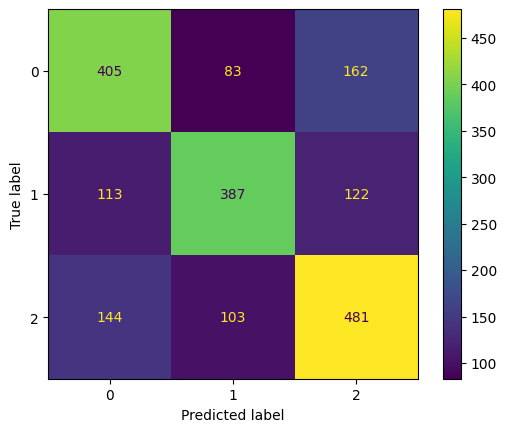

In [27]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm) 
cm_display.plot()


# Step 5: Experimenting with Other Models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

results = []

def evaluate_model(model, model_name):
    if model_name == 'Gaussian Naive Bayes':
        # GaussianNB requires dense matrix input
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_test_dense)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Append results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Print results immediately after training
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

# Step 3: Define and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    evaluate_model(model, model_name)

# Step 4: Display sorted results at the end
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print("\nFinal Model Performance Comparison (sorted by Accuracy):")
print(results_df)


Results for Logistic Regression:
Accuracy: 0.6365, Precision: 0.6378, Recall: 0.6365, F1 Score: 0.6366

Results for Multinomial Naive Bayes:
Accuracy: 0.5375, Precision: 0.5422, Recall: 0.5375, F1 Score: 0.5363

Results for Gaussian Naive Bayes:
Accuracy: 0.5305, Precision: 0.5332, Recall: 0.5305, F1 Score: 0.5303

Results for Support Vector Machine:
Accuracy: 0.6205, Precision: 0.6235, Recall: 0.6205, F1 Score: 0.6194

Results for Random Forest:
Accuracy: 0.6285, Precision: 0.6611, Recall: 0.6285, F1 Score: 0.6249

Results for Gradient Boosting:
Accuracy: 0.6755, Precision: 0.6886, Recall: 0.6755, F1 Score: 0.6752

Results for Decision Tree:
Accuracy: 0.5475, Precision: 0.5478, Recall: 0.5475, F1 Score: 0.5476

Results for K-Nearest Neighbors:
Accuracy: 0.4325, Precision: 0.4589, Recall: 0.4325, F1 Score: 0.4221


Final Model Performance Comparison (sorted by Accuracy):
                     Model  Accuracy  Precision  Recall  F1 Score
5        Gradient Boosting    0.6755   0.688623  0

# Step 6: Saving the trained model

In [16]:
import joblib

# Save the trained model
joblib.dump(model, 'news_bias_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']